In [1]:
import numpy as np
import pandas as pd
import os

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import pywt
from PIL import Image  
import PIL  
from skimage.io import imsave, imread

In [3]:
from dask import bag, diagnostics 
#import hvplot.pandas
from matplotlib import pyplot as plt
%matplotlib inline

In [4]:
import shutil

import cv2
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay, zero_one_loss, classification_report
import seaborn as sns
from tensorflow import keras
import matplotlib.cm as cm
from IPython.display import Image, display

from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten
from keras.layers import Input
from keras.layers import Convolution2D , concatenate ,Conv2D,Dense
from keras.layers import Activation,Dropout, GlobalAveragePooling2D,MaxPooling2D
from keras.models import Model
from keras.optimizers import Adam ,SGD,RMSprop

In [5]:
import math
from keras.layers import MaxPool2D, concatenate, AveragePooling2D
import tensorflow as tf
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint
import h5py
from keras.layers import Concatenate
import keras.backend as K
import keras
from keras.utils import np_utils
from keras.callbacks import LearningRateScheduler

In [6]:
data_path = '/content/drive/MyDrive/Sem 2/CV/5G_Data/'

In [7]:
classes = list(os.listdir('/content/drive/MyDrive/Sem 2/CV/5G_Data/'))
print(classes)

['4QAM', '64QAM', '16QAM', '32QAM', '8QAM']


In [8]:
directories = {
    '4QAM': '/content/drive/MyDrive/Sem 2/CV/5G_Data_rev/4QAM/',
    '8QAM': '/content/drive/MyDrive/Sem 2/CV/5G_Data/8QAM/',
    '16QAM': '/content/drive/MyDrive/Sem 2/CV/5G_Data_rev/16QAM/',
    '32QAM': '/content/drive/MyDrive/Sem 2/CV/5G_Data/32QAM/',
    '64QAM': '/content/drive/MyDrive/Sem 2/CV/5G_Data_rev/64QAM/',}

In [9]:
# get image dimensions
def get_dims(file):
    img = cv2.imread(file)
    h,w = img.shape[:2]
    return h,w

[########################################] | 100% Completed | 11.26 s
[########################################] | 100% Completed | 9.09 s
[########################################] | 100% Completed | 5.94 s
[########################################] | 100% Completed | 7.73 s
[########################################] | 100% Completed | 7.58 s


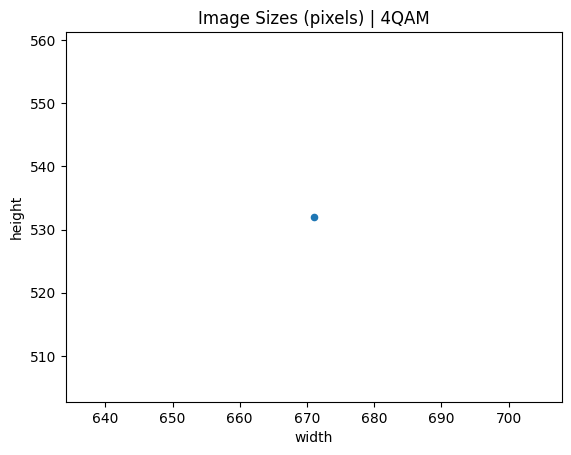

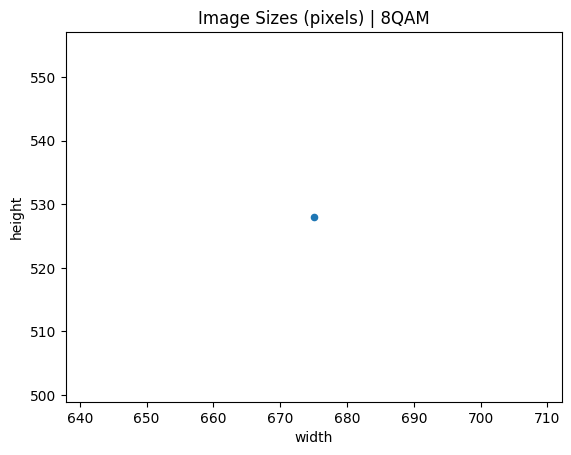

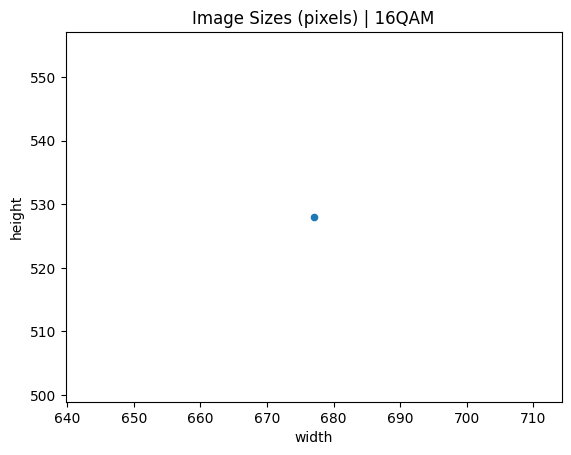

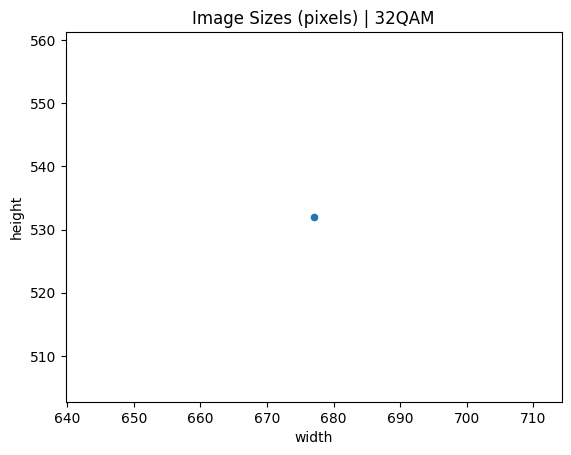

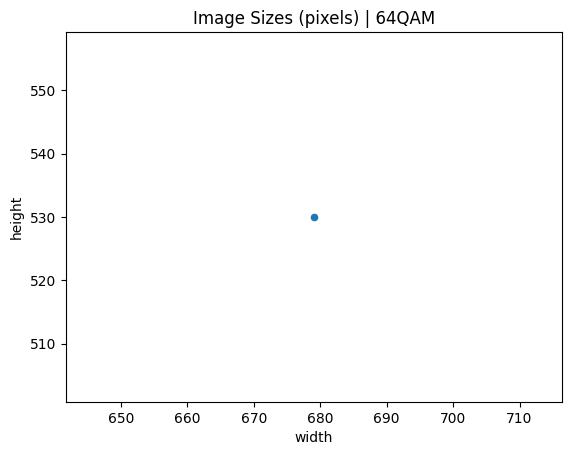

In [10]:
for n,d in directories.items():
  filepath = d
  filelist = [filepath + f for f in os.listdir(filepath)]
  dims = bag.from_sequence(filelist).map(get_dims)
  with diagnostics.ProgressBar():
    dims = dims.compute()
    dim_df = pd.DataFrame(dims, columns=['height', 'width'])
    sizes = dim_df.groupby(['height', 'width']).size().reset_index().rename(columns={0:'count'})
    sizes.plot.scatter(x='width', y='height');
    plt.title('Image Sizes (pixels) | {}'.format(n))

# **Scolograms**

In [11]:
dir = directories['64QAM']
label = '64QAM'

def plot_samples(dir, label):
  from tensorflow.keras.preprocessing import image

  fig = plt.figure(figsize = (8,6))
  filelist = [filepath + f for f in os.listdir(dir)]
  files = np.random.choice(filelist, 6, replace = False)
  plt.title(label)
  plt.axis('off')

  for i in range(6):
      ax = fig.add_subplot(2, 3, i+1)
      fn = image.load_img(files[i], target_size = (100,100))
      plt.imshow(fn)
      plt.axis('off')
  plt.show()

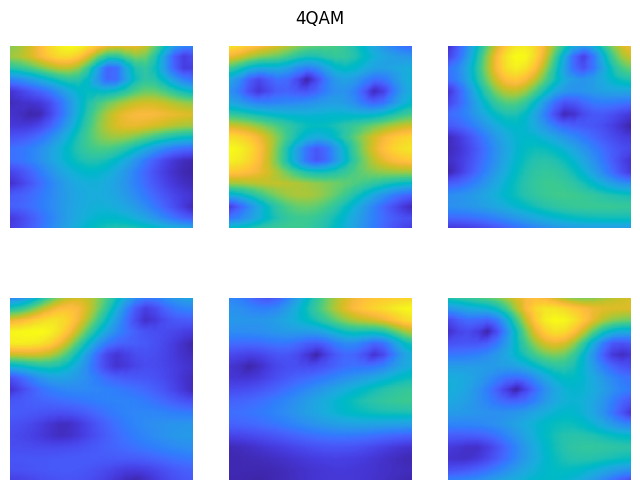

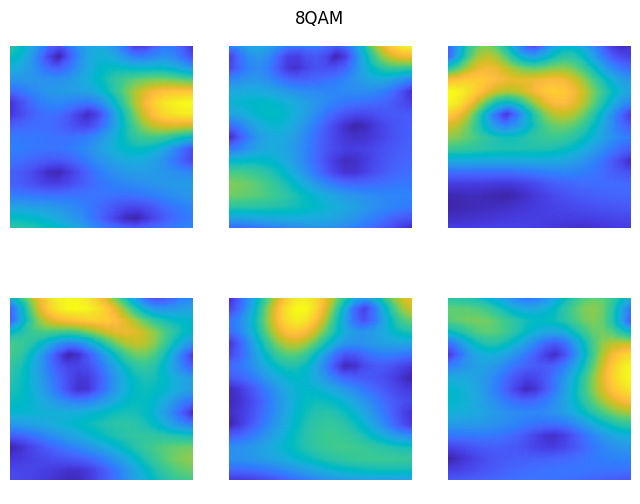

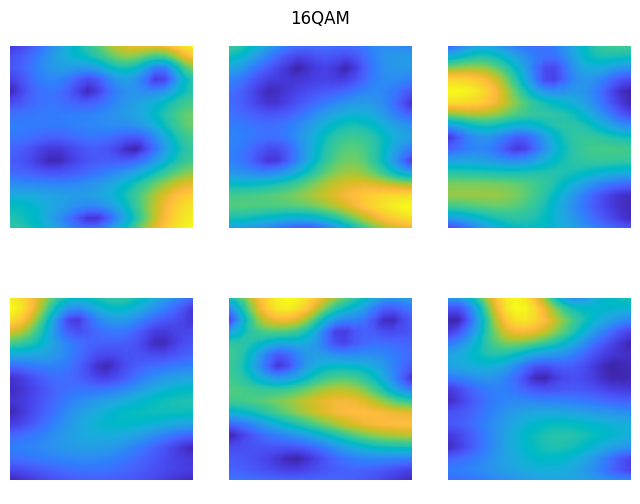

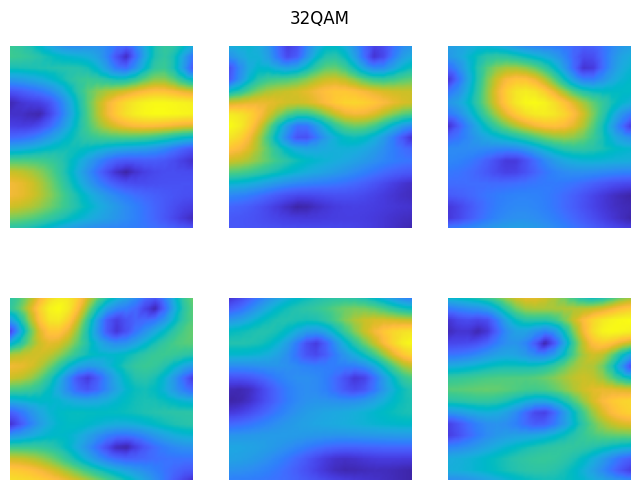

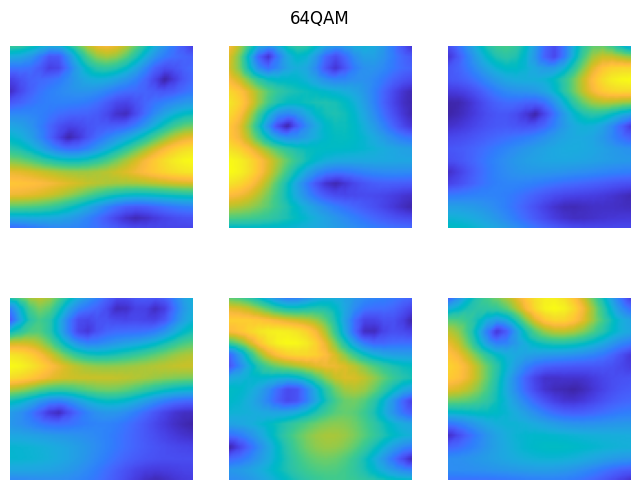

In [12]:
for n,dir in directories.items():
  plot_samples(d,n)

In [13]:
import PIL.Image

def cs_images(path,img_shape, classes):
    imag = []
    label = []
    for i in classes:
        l1 = os.listdir(path+'/'+i)
        for j in l1:
            img = PIL.Image.open(path+'/'+i+'/'+j)
            img = img.resize(size = (img_shape[0], img_shape[0]))
            img = img.convert('RGB')
            #img = img.convert('L')
            #img = img.reshape(50,50,1)
            #img = img.flatten()
            img = cv2.imread(path+'/'+i+'/'+j)
            img = cv2.resize(img,(img_shape[0],img_shape[1]),3)
            #img = np.array(img).reshape(img_shape)
            #img = img.reshape(img_shape)
            imag.append(img)
            label.append(classes.index(i))
            del(img)
    # %matplotlib inline 
    # plt.figure(figsize=(10, 10))
    # for i in range(20):
    #     plt.subplot(5,4,i+1)
    #     plt.imshow(imag[i])
    #     plt.axis('off')
    # plt.show()
    return np.array(imag),label

In [14]:
IMG_SIZE = 224

In [15]:
x,y = cs_images(data_path,(IMG_SIZE, IMG_SIZE, 1),classes)

In [16]:
y = pd.Series(y)

In [17]:
x_train,x_test,y_train,y_test = train_test_split(x,y,
                                                 test_size = 0.2,
                                                 random_state = 12,
                                                 shuffle = True)

In [18]:
x_train = x
y_train = y

In [19]:
x_train.shape

(2002, 224, 224, 3)

In [20]:
y_train[:10]

0    0
1    0
2    0
3    0
4    0
5    0
6    0
7    0
8    0
9    0
dtype: int64

In [21]:
y_train.shape

(2002,)

In [22]:
x_test.shape

(401, 224, 224, 3)

In [23]:
y_test.shape

(401,)

In [24]:
IMG_SIZE = 224

# **Mobilenet Model**

In [25]:
IMG_SIZE = 224
BATCH_SIZE = 32

In [26]:
data_augmentation = tf.keras.Sequential([
                            layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
                            layers.experimental.preprocessing.RandomRotation((-0.2, 0.3))
])

In [27]:
resize_and_rescale = tf.keras.Sequential([
            layers.experimental.preprocessing.Resizing(IMG_SIZE, IMG_SIZE, input_shape=[IMG_SIZE,IMG_SIZE,3]),
            layers.experimental.preprocessing.Rescaling(1./255)
])
# resize_and_rescale = keras.Sequential([
#   layers.Resizing(IMG_SIZE, IMG_SIZE),
#   layers.Rescaling(1./255)
# ])

In [28]:
from tensorflow.keras.constraints import MaxNorm

def mobileNet(inp_shape):
  model = Sequential()
  model.add(resize_and_rescale)
  model.add(data_augmentation)
  model.add(MobileNetV2(include_top = False, weights="imagenet", input_shape=inp_shape))
  model.add(Dropout(0.1))
  model.add(Dense(15, activation='relu', kernel_constraint=MaxNorm(3)))
  model.add(Dropout(0.1))
  model.add(tf.keras.layers.GlobalAveragePooling2D())
  model.add(Dense(5, activation = 'softmax'))
  model.layers[0].trainable = False

  return model

In [67]:
model_mnet = mobileNet((IMG_SIZE, IMG_SIZE, 3))

In [30]:
opt = tf.keras.optimizers.Adagrad(
    learning_rate= 0.1,
    initial_accumulator_value=0.1,
    epsilon=1e-07,
    weight_decay=None,
    clipnorm=None,
    clipvalue=None,
    global_clipnorm=None,
    use_ema=False,
    ema_momentum=0.99,
    ema_overwrite_frequency=None,
    jit_compile=True,
    name="Adagrad",
    #**kwargs
)

### AdaGrad lr = 1

In [68]:
opt = tf.keras.optimizers.experimental.SGD(0.1, momentum=0.1)

model_mnet.compile(optimizer= opt, #tf.optimizers.SGD(lr=0.001), 
                   loss = 'sparse_categorical_crossentropy',
                   metrics = 'accuracy')

In [69]:
model_mnet.build((IMG_SIZE, IMG_SIZE, 3))

In [70]:
model_mnet.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 dropout_7 (Dropout)         (None, 7, 7, 1280)        0         
                                                                 
 dense_8 (Dense)             (None, 7, 7, 15)          19215     
                                                                 
 dropout_8 (Dropout)         (None, 7, 7, 15)          0         
                                                      

In [34]:
es = [
    keras.callbacks.EarlyStopping(
        # Stop training when `val_loss` is no longer improving
        monitor='val_loss',
        # "no longer improving" being defined as "no better than 1e-2 less"
        min_delta=1e-3,
        # "no longer improving" being further defined as "for at least 2 epochs"
        patience=25,
        verbose=1)
]

In [35]:
from keras.callbacks import EarlyStopping

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)

In [ ]:
import torch
device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")
print(device)

In [72]:
hist_mnet = model_mnet.fit( x_train,
                           y_train,
                           epochs= 30,
                           validation_data = (x_test,y_test),
                           verbose = 1,
                           #callbacks = [es]
                           )

Epoch 1/30
63/63 [==============================] - 13s 206ms/step - loss: 1.1163 - accuracy: 0.3666 - val_loss: 2.3048 - val_accuracy: 0.2170
Epoch 2/30
63/63 [==============================] - 12s 185ms/step - loss: 0.9827 - accuracy: 0.3996 - val_loss: 2.3436 - val_accuracy: 0.2170
Epoch 3/30
63/63 [==============================] - 12s 184ms/step - loss: 0.9653 - accuracy: 0.4136 - val_loss: 2.0574 - val_accuracy: 0.2170
Epoch 4/30
63/63 [==============================] - 11s 183ms/step - loss: 0.9601 - accuracy: 0.4186 - val_loss: 2.3965 - val_accuracy: 0.1995
Epoch 5/30
63/63 [==============================] - 11s 179ms/step - loss: 0.9547 - accuracy: 0.4021 - val_loss: 2.4426 - val_accuracy: 0.2170
Epoch 6/30
63/63 [==============================] - 11s 182ms/step - loss: 0.9553 - accuracy: 0.4086 - val_loss: 2.1087 - val_accuracy: 0.2170
Epoch 7/30
63/63 [==============================] - 11s 182ms/step - loss: 0.9588 - accuracy: 0.4146 - val_loss: 2.3049 - val_accuracy: 0.1970

In [73]:
y_pred = np.argmax(model_mnet.predict(x_test),axis=1)

13/13 [==============================] - 2s 40ms/step


In [74]:
y_pred[0:5]

array([4, 4, 4, 4, 4])

In [75]:
list(y_test[0:5])

[0, 3, 1, 2, 4]

In [76]:
model_mnet.evaluate(x_train,y_train)

63/63 [==============================] - 2s 36ms/step - loss: 2.6010 - accuracy: 0.2228


[2.601029634475708, 0.22277721762657166]

In [77]:
model_mnet.evaluate(x_test,y_test)

13/13 [==============================] - 0s 36ms/step - loss: 2.6554 - accuracy: 0.2045


[2.6553776264190674, 0.20448878407478333]

In [78]:
print(classes)
print(y_test[:25], '\n')
print(y_pred[:25], '\n')

# predict = []
# for i in range(3000): #len(y_pred)
#   predict.append(np.argmax(y_pred[i]))

# print(predict[:25], '\n')

cm = confusion_matrix(y_test, y_pred)
print(cm, '\n')

zol = zero_one_loss(y_test, y_pred, normalize = False)
print(zol, '\n')

cr = classification_report(y_test, y_pred)
print(cr)

['4QAM', '64QAM', '16QAM', '32QAM', '8QAM']
369     0
1438    3
520     1
905     2
1984    4
1142    2
749     1
120     0
1717    4
61      0
1879    4
1191    2
786     1
651     1
858     2
242     0
1461    3
1031    2
342     0
825     2
283     0
823     2
1838    4
167     0
1166    2
dtype: int64 

[4 4 4 4 4 4 4 1 4 4 4 4 4 4 4 4 4 4 4 4 4 1 4 1 4] 

[[ 2 23  7  4 51]
 [ 0  0  0  0 81]
 [ 2 10  5  1 61]
 [ 0  0  0  0 79]
 [ 0  0  0  0 75]] 

319 

              precision    recall  f1-score   support

           0       0.50      0.02      0.04        87
           1       0.00      0.00      0.00        81
           2       0.42      0.06      0.11        79
           3       0.00      0.00      0.00        79
           4       0.22      1.00      0.36        75

    accuracy                           0.20       401
   macro avg       0.23      0.22      0.10       401
weighted avg       0.23      0.20      0.10       401



<Figure size 500x500 with 0 Axes>

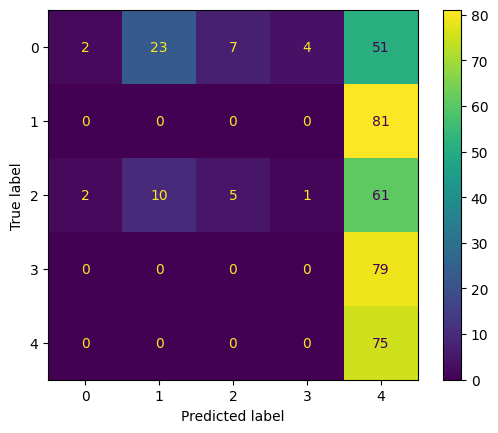

In [79]:
plt.figure(figsize = (5,5))
ConfusionMatrixDisplay(cm).plot()
plt.show()

In [44]:
print(hist_mnet.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


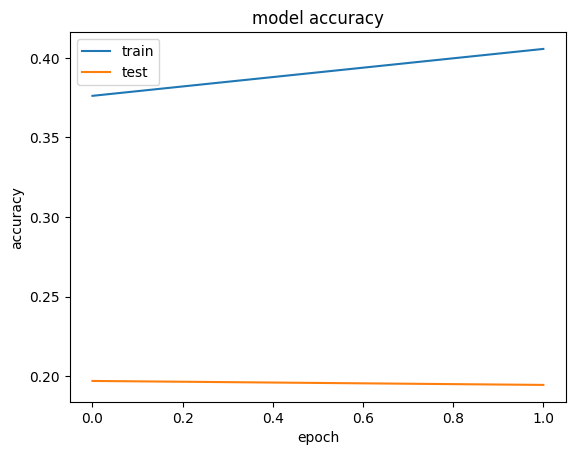

In [45]:
# summarize history for accuracy
plt.plot(hist_mnet.history['accuracy'])
plt.plot(hist_mnet.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

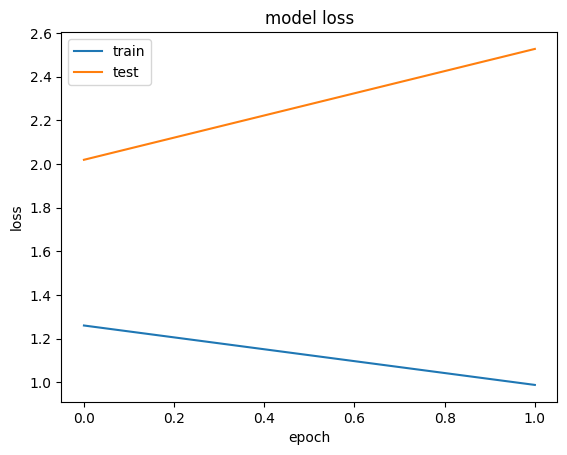

In [46]:
# summarize history for loss
plt.plot(hist_mnet.history['loss'])
plt.plot(hist_mnet.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# VGG

In [47]:
from glob import glob 
from tensorflow.keras.layers import Lambda
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [48]:

IMAGE_SIZE = [224, 224] #Default image size for VGG16

# ImageDataGenerator can help perform augumentation on existing images. This way, we get more diverse train set.

train_datagen = ImageDataGenerator(rescale = 1./255, shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True)

validation_datagen = ImageDataGenerator(rescale = 1./255)

test_datagen = ImageDataGenerator(rescale = 1./255)
#Through flow_from_directory - we create an array of images that can be used for training. 


In [49]:
#Create a VGG16 model, and removing the last layer that is classifying 1000 images. This will be replaced with images classes we have. 
#vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False) #Training with Imagenet weights
# Use this line for VGG19 network. Create a VGG19 model, and removing the last layer that is classifying 1000 images. This will be replaced with images classes we have. 


vgg = VGG19(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)
# This sets the base that the layers are not trainable. If we'd want to train the layers with custom data, these two lines can be ommitted. 
for layer in vgg.layers:
  layer.trainable = False

x = Flatten()(vgg.output) #Output obtained on vgg16 is now flattened. 
x = Dropout(0.3)(x)
x = Dense(30, activation='relu')(x)
prediction = Dense(len(classes), activation='softmax')(x) # We have 5 classes, and so, the prediction is being done on len(folders) - 5 classes
#Creating model object 
model = Model(inputs=vgg.input, outputs=prediction)
model.summary()

80134624/80134624 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

In [54]:
base_model = VGG19(input_shape=(IMG_SIZE,IMG_SIZE,3), include_top=False, weights='imagenet')
# Set all layers to non-trainable
for layer in base_model.layers:
    layer.trainable = False
# Set the last vgg block to trainable
base_model.layers[-2].trainable = True
base_model.layers[-3].trainable = True
base_model.layers[-4].trainable = True

model = Sequential()
model.add(Input(shape=(IMG_SIZE,IMG_SIZE,3)))
model.add(base_model)
model.add(Flatten())
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(len(classes), activation='softmax'))

In [55]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten_2 (Flatten)         (None, 25088)             0         
                                                                 
 dropout_5 (Dropout)         (None, 25088)             0         
                                                                 
 dense_6 (Dense)             (None, 128)               3211392   
                                                                 
 dropout_6 (Dropout)         (None, 128)               0         
                                                                 
 dense_7 (Dense)             (None, 5)                 645       
                                                                 
Total params: 23,236,421
Trainable params: 10,291,461


In [56]:
#opt = keras.optimizers.Adam(learning_rate=0.01)
opt = tf.keras.optimizers.experimental.SGD(0.01, momentum=0.01, clipnorm = 1)
#Compile the model 
model.compile(loss='sparse_categorical_crossentropy', 
              optimizer= opt, 
              metrics=['sparse_categorical_accuracy']) 

In [57]:
history = model.fit(x_train,
                    y_train,
                    epochs= 30,
                    validation_data = (x_test,y_test),
                    verbose = 1,
                    #callbacks = [es],
                    batch_size=32)

Epoch 1/30
63/63 [==============================] - 15s 218ms/step - loss: 2.6038 - sparse_categorical_accuracy: 0.3437 - val_loss: 1.0764 - val_sparse_categorical_accuracy: 0.4015
Epoch 2/30
63/63 [==============================] - 14s 221ms/step - loss: 1.1016 - sparse_categorical_accuracy: 0.4296 - val_loss: 0.9645 - val_sparse_categorical_accuracy: 0.4514
Epoch 3/30
63/63 [==============================] - 14s 215ms/step - loss: 1.0008 - sparse_categorical_accuracy: 0.4441 - val_loss: 0.9937 - val_sparse_categorical_accuracy: 0.4613
Epoch 4/30
63/63 [==============================] - 14s 218ms/step - loss: 0.9802 - sparse_categorical_accuracy: 0.4326 - val_loss: 0.8873 - val_sparse_categorical_accuracy: 0.5212
Epoch 5/30
63/63 [==============================] - 13s 215ms/step - loss: 0.9402 - sparse_categorical_accuracy: 0.4660 - val_loss: 0.8586 - val_sparse_categorical_accuracy: 0.5511
Epoch 6/30
63/63 [==============================] - 13s 214ms/step - loss: 0.8962 - sparse_cate

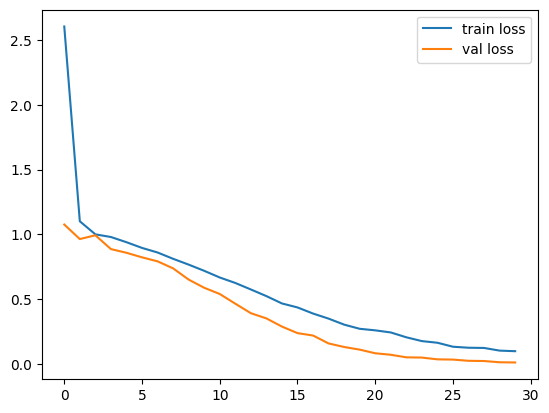

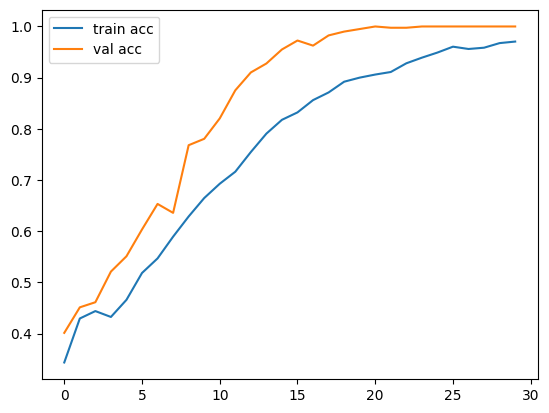

In [59]:
# loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()
 
 # accuracies
plt.plot(history.history['sparse_categorical_accuracy'], label='train acc')
plt.plot(history.history['val_sparse_categorical_accuracy'], label='val acc')
plt.legend()
plt.show()

In [60]:
from tensorflow.keras.models import load_model
model.save('/content/drive/MyDrive/Sem 2/CV/Saved_models/5g_1_data_vgg19.h5')

In [61]:
y_pred = np.argmax(model.predict(x_test),axis=1)

13/13 [==============================] - 2s 151ms/step


In [62]:
y_pred[0:5]

array([0, 3, 1, 2, 4])

In [63]:
list(y_test[0:5])

[0, 3, 1, 2, 4]

In [64]:
model.evaluate(x_test,y_test)

13/13 [==============================] - 2s 151ms/step - loss: 0.0127 - sparse_categorical_accuracy: 1.0000


[0.012708069756627083, 1.0]

In [65]:
print(classes)
# print(y_test[:25], '\n')
# print(y_pred[:25], '\n')

# predict = []
# for i in range(3000): #len(y_pred)
#   predict.append(np.argmax(y_pred[i]))

# print(predict[:25], '\n')

cm = confusion_matrix(y_test, y_pred)
print(cm, '\n')

zol = zero_one_loss(y_test, y_pred, normalize = False)
print(zol, '\n')

cr = classification_report(y_test, y_pred)
print(cr)

['4QAM', '64QAM', '16QAM', '32QAM', '8QAM']
[[87  0  0  0  0]
 [ 0 81  0  0  0]
 [ 0  0 79  0  0]
 [ 0  0  0 79  0]
 [ 0  0  0  0 75]] 

0 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        87
           1       1.00      1.00      1.00        81
           2       1.00      1.00      1.00        79
           3       1.00      1.00      1.00        79
           4       1.00      1.00      1.00        75

    accuracy                           1.00       401
   macro avg       1.00      1.00      1.00       401
weighted avg       1.00      1.00      1.00       401



<Figure size 500x500 with 0 Axes>

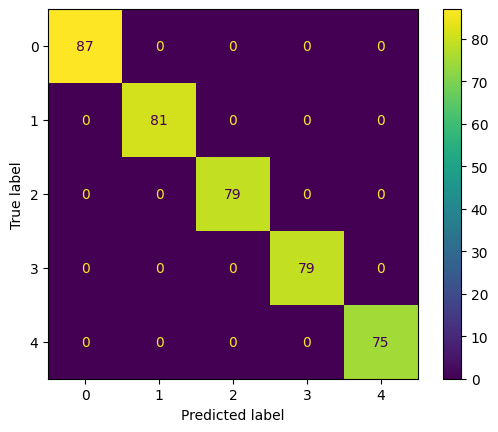

In [66]:
plt.figure(figsize = (5,5))
ConfusionMatrixDisplay(cm).plot()
plt.show()